In [1]:
import scanpy as sc #for scanpy >= 1.3.7
import anndata as ann
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scvi

In [2]:
adata = sc.read_h5ad("ferret_anndata_objects/ferret_bipolar_annotation_prep_checkpoint.h5ad")

## Cluster Annotation with scANVI 

In [3]:
scvi.data.setup_anndata(
    adata, 
    layer="counts",
    batch_key="batch", 
    labels_key="type", 
)

INFO     Using batches from adata.obs["batch"]                                               
INFO     Using labels from adata.obs["type"]                                                 
INFO     Using data from adata.layers["counts"]                                              
INFO     Computing library size prior per batch                                              
INFO     Successfully registered anndata object containing 33617 cells, 9695 vars, 9 batches,
         21 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0     
         extra continuous covariates.                                                        
INFO     Please do not further modify adata until model is trained.                          


In [4]:
lvae = scvi.model.SCANVI(adata, "Unknown", n_latent=30, n_layers=2)

In [5]:
lvae.train(max_epochs = 100)

INFO     Training for 100 epochs.                                                            


GPU available: False, used: False
TPU available: None, using: 0 TPU cores


Epoch 100/100: 100%|██████████| 100/100 [1:56:35<00:00, 69.95s/it, loss=2.33e+03, v_num=1]


In [6]:
adata.obs["C_scANVI"] = lvae.predict(adata)
adata.obsm["X_scANVI"] = lvae.get_latent_representation(adata)

In [7]:
sc.pp.neighbors(adata, use_rep="X_scANVI")
sc.tl.umap(adata)

In [8]:
sc.tl.tsne(adata, n_pcs=50, use_rep="X_scANVI")

... storing 'C_scANVI' as categorical


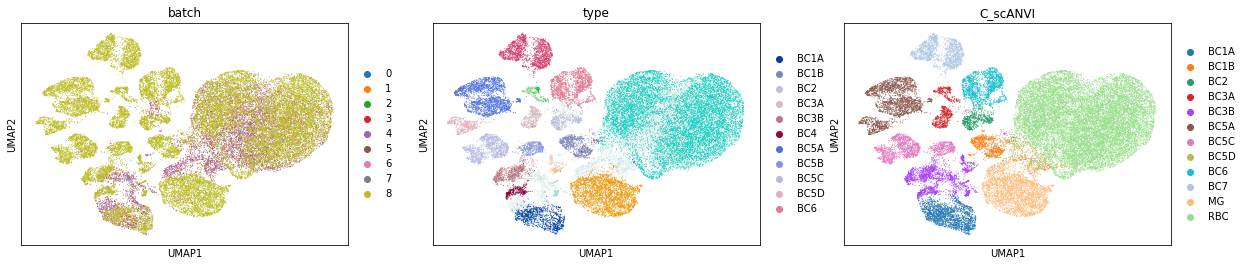

In [9]:
sc.pl.umap(adata, color= ["batch", "type", "C_scANVI"])

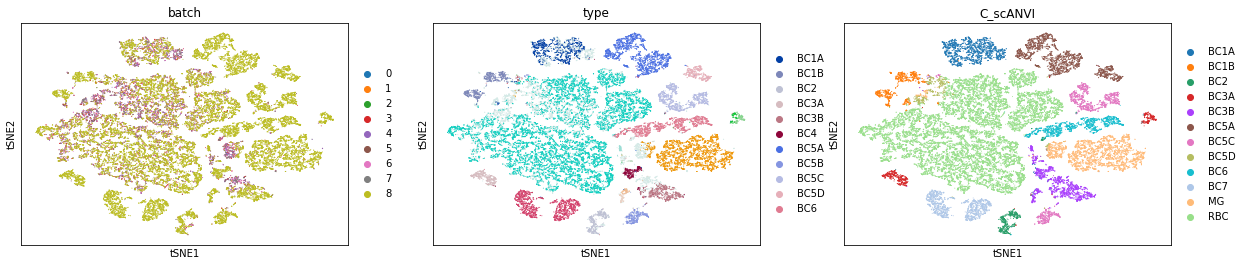

In [10]:
sc.pl.tsne(adata, color=["batch", "type", "C_scANVI"])

In [11]:
adata.write("ferret_bipolar_annotation_checkpoint_no_subcluster.h5ad")

In [12]:
adata

AnnData object with n_obs × n_vars = 33617 × 9695
    obs: 'batch', 'n_counts', 'log_counts', 'n_genes', 'mt_frac', 'annotated', 'annotated_specific', 'type', '_scvi_batch', '_scvi_labels', '_scvi_local_l_mean', '_scvi_local_l_var', 'C_scANVI'
    var: 'gene_ids-0', 'n_cells-0', 'n_cells-1', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'batch_colors', 'hvg', '_scvi', 'neighbors', 'umap', 'type_colors', 'C_scANVI_colors'
    obsm: 'X_scANVI', 'X_umap', 'X_tsne'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

## Removing Reference Cells and Plotting UMAP/TSNE

In [13]:
adata_1 = sc.read_h5ad("ferret_bipolar_annotation_checkpoint_no_subcluster.h5ad")

In [14]:
adata_1

AnnData object with n_obs × n_vars = 33617 × 9695
    obs: 'batch', 'n_counts', 'log_counts', 'n_genes', 'mt_frac', 'annotated', 'annotated_specific', 'type', '_scvi_batch', '_scvi_labels', '_scvi_local_l_mean', '_scvi_local_l_var', 'C_scANVI'
    var: 'gene_ids-0', 'n_cells-0', 'n_cells-1', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'C_scANVI_colors', '_scvi', 'batch_colors', 'hvg', 'neighbors', 'type_colors', 'umap'
    obsm: 'X_scANVI', 'X_tsne', 'X_umap'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [15]:
## Remove Reference Data
adata_no_reference = adata_1[~adata_1.obs['batch'].isin(['8']),:]

In [16]:
adata_no_reference

View of AnnData object with n_obs × n_vars = 8943 × 9695
    obs: 'batch', 'n_counts', 'log_counts', 'n_genes', 'mt_frac', 'annotated', 'annotated_specific', 'type', '_scvi_batch', '_scvi_labels', '_scvi_local_l_mean', '_scvi_local_l_var', 'C_scANVI'
    var: 'gene_ids-0', 'n_cells-0', 'n_cells-1', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'C_scANVI_colors', '_scvi', 'batch_colors', 'hvg', 'neighbors', 'type_colors', 'umap'
    obsm: 'X_scANVI', 'X_tsne', 'X_umap'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

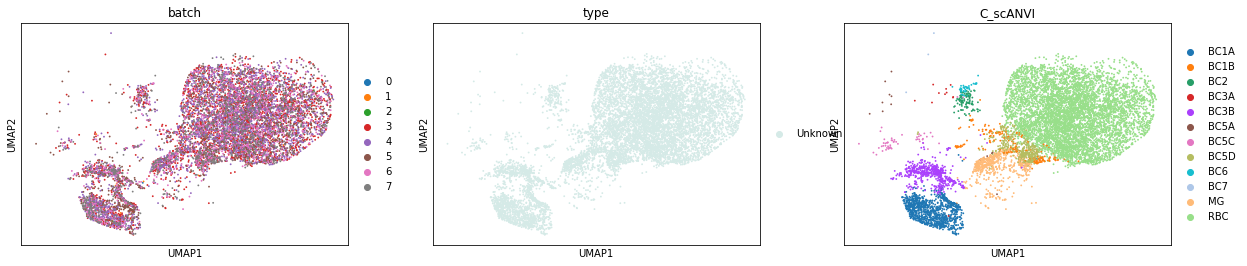

In [17]:
sc.pl.umap(adata_no_reference, color = ["batch", "type", "C_scANVI"])

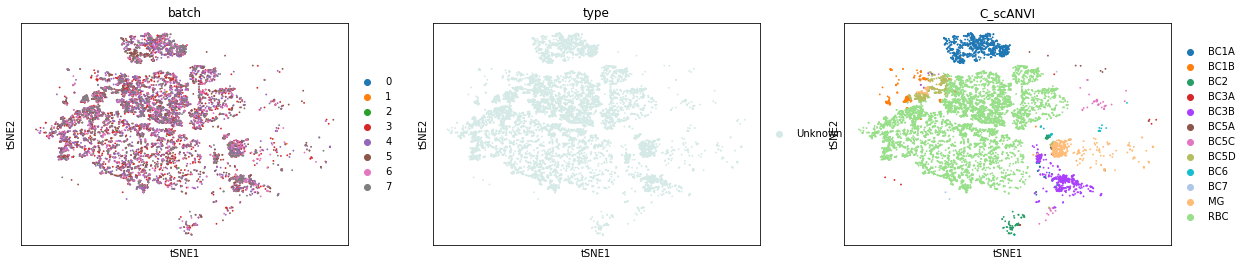

In [18]:
sc.pl.tsne(adata_no_reference, color = ["batch", "type", "C_scANVI"])

In [19]:
adata_no_reference.write("ferret_bipolar_annotation_removed_reference_checkpoint_no_subcluster.h5ad")

In [20]:
df = adata.obs.groupby(["type", "C_scANVI"]).size().unstack(fill_value=0)

Text(0, 0.5, 'Observed')

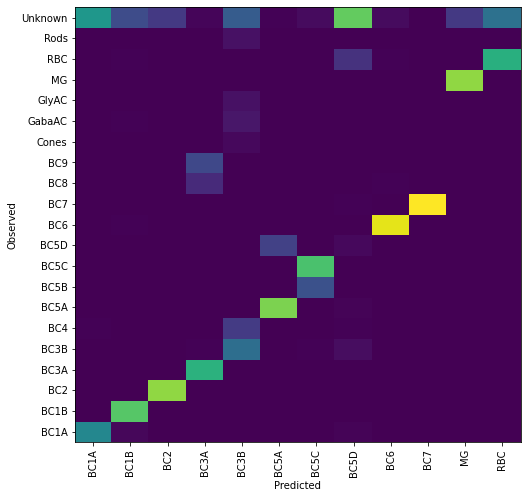

In [21]:
df = df / df.sum(axis=0)

plt.figure(figsize=(8, 8))
_ = plt.pcolor(df)
_ = plt.xticks(np.arange(0.5, len(df.columns), 1), df.columns, rotation=90)
_ = plt.yticks(np.arange(0.5, len(df.index), 1), df.index)
plt.xlabel("Predicted")
plt.ylabel("Observed")